
# 🧪 **AI-Driven Protein Sequence Design with ProGen2 — Dataset → LoRA Fine-tuning → Comparative Analysis**


This notebook presents a complete end-to-end pipeline for AI-assisted protein design:

1. **Public Dataset (UniProt EC 3.\*)** → loading, cleaning, statistics, catalytic triad motif detection (*Ser–Asp–His*).  
2. **Baseline** generation with ProGen2-small (mirror) → conditional sequence generation → filtering → **ESMFold API** → pLDDT scoring.  
3. **Lightweight Fine-tuning** (LoRA/PEFT) → targeting the same objective (hydrolases, 200–400 aa).  
4. **Comparison** before vs. after fine-tuning (motif retention, pLDDT distribution, other relevant metrics).



##  Preamble & Version Check (Quick Diagnostics)

This block performs a quick environment check to ensure all dependencies, GPU availability, and package versions are correctly set before running the pipeline.


In [ ]:
import torch, sys, importlib, platform
print("Python  :", sys.version.split()[0], platform.platform())
print("Torch   :", torch.__version__)
try:
    import transformers, peft, datasets, tokenizers
    print("HF Transformers:", transformers.__version__)
    print("PEFT           :", peft.__version__)
    print("datasets       :", datasets.__version__)
    print("tokenizers     :", tokenizers.__version__)
except Exception as e:
    print("Imports manquants:", e)


Python  : 3.11.13 Linux-6.1.123+-x86_64-with-glibc2.35
Torch   : 2.6.0+cu124
HF Transformers: 4.55.0
PEFT           : 0.17.0
datasets       : 4.0.0
tokenizers     : 0.21.4


## Utilities: Sequence Features & pLDDT

Functions to:
- Clean sequences and compute features (composition, hydrophobicity, net charge).
- Check catalytic triad presence (Ser–Asp–His).
- Parse per-residue pLDDT from ESMFold PDB files.


In [ ]:
import re, numpy as np, pandas as pd

# Set of standard amino acids (20 types)
AA_STD = set("ACDEFGHIKLMNPQRSTVWY")

# Clean a protein sequence: keep only valid amino acids (optionally allow 'X')
def clean_seq(s: str, allow_x_ratio=0.0):
    s = re.sub(r"[^ACDEFGHIKLMNPQRSTVWYX]", "", str(s).upper())  # Keep only AA + optional X
    if allow_x_ratio <= 0 and "X" in s:
        s = s.replace("X", "")  # Remove 'X' completely if not allowed
    elif allow_x_ratio > 0 and s:
        if s.count("X") / len(s) > allow_x_ratio:  # Too many 'X' → discard
            return ""
    return s

# Compute amino acid composition (fraction of each AA)
def aa_composition(seq: str):
    seq = clean_seq(seq)
    n = len(seq) or 1
    return {a: seq.count(a) / n for a in "ACDEFGHIKLMNPQRSTVWY"}

# Kyte–Doolittle hydrophobicity scale (approximate mean score)
KD = dict(zip(
    "IVLFCMAWTGSPHYQNEDKR",
    [4.5, 4.2, 3.8, 2.5, 2.8, 1.9, -0.9, -0.4, -0.7, -1.3,
     -1.6, -0.8, -3.2, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.9]
))
def kd_hydrophobicity(seq: str):
    s = clean_seq(seq)
    return float(np.mean([KD.get(a, -1.0) for a in s])) if s else -10.0

# Estimate net charge at pH 7 (approximate)
def net_charge_pH7(seq: str):
    s = clean_seq(seq)
    pos = sum(s.count(a) for a in "KRH")  # Positive residues
    neg = sum(s.count(a) for a in "DE")   # Negative residues
    return float(pos - neg)

# Detect catalytic triad Ser-Asp-His (simple presence check)
def has_triad_ser_asp_his(seq: str):
    s = clean_seq(seq)
    return ("S" in s) and ("D" in s) and ("H" in s)

# Parse pLDDT scores from an ESMFold PDB file (B-factor column)
def parse_residue_plddt_norm(pdb_path: str):
    vals = {}
    try:
        with open(pdb_path, "r") as f:
            for line in f:
                if line.startswith("ATOM") and len(line) >= 66:
                    resi = int(line[22:26])     # Residue number
                    b = float(line[60:66])      # pLDDT score
                    vals[resi] = b
    except Exception:
        pass
    return vals


## Load UniProt Hydrolases

Load TSV dataset, clean sequences, keep length 200–400 AA,  
and optionally filter EC numbers starting with `3.`.


In [ ]:
import os

# Check that the dataset file exists
assert os.path.exists("data/uniprot_hydrolases_200_400.tsv"), "Dataset file is missing."

# Load the dataset from TSV file
df = pd.read_csv("data/uniprot_hydrolases_200_400.tsv", sep="\t")

# Basic safety cleaning: keep only valid amino acids
df["sequence"] = df["sequence"].map(clean_seq)

# Remove rows with missing sequences
df = df.dropna(subset=["sequence"]).copy()

# Keep only sequences between 200 and 400 amino acids
df = df[(df["sequence"].str.len() >= 200) & (df["sequence"].str.len() <= 400)].copy()

# Optional: filter to ensure EC number starts with "3."
def has_ec3(s):
    if pd.isna(s):
        return False
    ecs = [e.strip() for e in str(s).split(";") if e.strip()]
    return any(e.startswith("3.") for e in ecs)

# Apply EC filter if column exists
if "ec" in df.columns:
    df = df[df["ec"].notna() & df["ec"].apply(has_ec3)].copy()

# Show dataset size and first two rows
len(df), df.head(2)


(25873,
   accession           id                                     protein_name  \
 0    O00115  DNS2A_HUMAN                        Deoxyribonuclease-2-alpha   
 1    O00487   PSDE_HUMAN  26S proteasome non-ATPase regulatory subunit 14   
 
          ec      organism  length  \
 0  3.1.22.1  Homo sapiens     360   
 1  3.4.19.-  Homo sapiens     310   
 
                                             sequence  len  triad  
 0  MIPLLLAALLCVPAGALTCYGDSGQPVDWFVVYKLPALRGSGEAAQ...  360   True  
 1  MDRLLRLGGGMPGLGQGPPTDAPAVDTAEQVYISSLALLKMLKHGR...  310   True  )

## Baseline Sequence Generation

Generate sequences with `ProGen2-small` using a fixed starter motif ("1M"),  
clean them, and keep those ≥ 50 AA for baseline comparison.


In [ ]:
import torch
from transformers import AutoModelForCausalLM
from tokenizers import Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "hugohrban/progen2-small"

base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True).to(device).eval()
tok_fast = Tokenizer.from_pretrained(MODEL_ID)
tok_fast.no_padding()

EOS_ID = base_model.config.eos_token_id or 2

def generate_baseline(n=100, starter="1M", max_new=256, temperature=0.9, top_p=0.95, seed=42):
    torch.manual_seed(seed)
    seqs = []
    enc = tok_fast.encode(starter)
    input_ids = torch.tensor([enc.ids], dtype=torch.long, device=base_model.device)
    for _ in range(n):
        out = base_model.generate(
            input_ids=input_ids,
            do_sample=True, temperature=temperature, top_p=top_p,
            max_new_tokens=max_new, eos_token_id=EOS_ID,
        )[0].tolist()
        txt = tok_fast.decode(out)
        txt = txt.split(starter, 1)[-1]
        seq = clean_seq(txt)
        if len(seq) >= 50:
            seqs.append(seq)
    return seqs

baseline_seqs = generate_baseline(n=100, starter="1M")
len(baseline_seqs), baseline_seqs[:3]


## Scoring, Filtering & Structure Prediction

- Score sequences (length, hydrophobicity, charge, triad, composition).  
- Filter by thresholds and export top candidates (.csv, .fasta).  
- Optionally fold with ESM Atlas API and compute mean pLDDT.


In [1]:
import time, requests

LEN_MIN, LEN_MAX = 200, 400
KD_MIN, KD_MAX   = -1.0, 2.0
CH_MIN, CH_MAX   = -5,   5

def score_and_filter(name, seqs, topk=20, outdir="outputs"):
    rows = []
    for i, s in enumerate(seqs, 1):
        comp = aa_composition(s)
        rows.append({
            "id": f"{name}_{i}",
            "sequence": s,
            "length": len(s),
            "kd": kd_hydrophobicity(s),
            "charge": net_charge_pH7(s),
            "triad": has_triad_ser_asp_his(s),
            **{f"f_{k}": v for k, v in comp.items()}
        })
    df_sc = pd.DataFrame(rows).set_index("id")

    mask = (
        df_sc["length"].between(LEN_MIN, LEN_MAX) &
        df_sc["kd"].between(KD_MIN, KD_MAX) &
        df_sc["charge"].between(CH_MIN, CH_MAX) &
        df_sc["triad"]
    )
    filtered = df_sc[mask].copy().sort_values(["triad", "length"], ascending=[False, True])
    best = filtered.head(min(topk, len(filtered))).copy()

    os.makedirs(f"{outdir}/{name}", exist_ok=True)
    best.to_csv(f"{outdir}/{name}/top_candidates_{name}.csv")
    with open(f"{outdir}/{name}/top_candidates_{name}.fasta", "w") as f:
        for idx, row in best.iterrows():
            f.write(f">{idx}\n{row['sequence']}\n")
    print(f"{name}: {len(seqs)} generated → {len(filtered)} filtered → {len(best)} TOP exported.")
    return df_sc, filtered, best

def fold_with_esmfasta(best_df, name, outdir="outputs", timeout=180):
    os.makedirs(f"{outdir}/{name}/pdbs", exist_ok=True)
    manifest_rows = []
    for idx, row in best_df.iterrows():
        seq_id = idx
        seq = row["sequence"]
        out_pdb = f"{outdir}/{name}/pdbs/{seq_id}.pdb"
        if os.path.exists(out_pdb) and os.path.getsize(out_pdb) > 0:
            status = "cached"
        else:
            status = "error"
            for attempt in range(4):
                try:
                    r = requests.post("https://api.esmatlas.com/foldSequence/v1/pdb/", data=seq, timeout=timeout)
                    txt = r.text or ""
                    if r.status_code == 200 and "ATOM" in txt:
                        open(out_pdb, "w").write(txt)
                        status = "ok"
                        break
                    elif r.status_code in (429, 500, 502, 503, 504):
                        time.sleep(2 * (attempt + 1))
                        continue
                    else:
                        open(f"{outdir}/{name}/{seq_id}.log", "w").write(txt[:800])
                        break
                except requests.RequestException:
                    time.sleep(2 * (attempt + 1))
        manifest_rows.append({"id": seq_id, "pdb_path": out_pdb if status == "ok" else "", "status": status})
    mani = pd.DataFrame(manifest_rows).set_index("id")
    mani.to_csv(f"{outdir}/{name}/pdb_manifest_{name}.csv")
    return mani

def compute_plddt(manifest_df):
    rows = []
    for idx, row in manifest_df.iterrows():
        pdb_path = row["pdb_path"]
        if row["status"] == "ok" and isinstance(pdb_path, str) and os.path.exists(pdb_path):
            rp = parse_residue_plddt_norm(pdb_path)
            vals = list(rp.values())
            mean_plddt = float(np.mean(vals)) if vals else 0.0
        else:
            mean_plddt = 0.0
        rows.append({"id": idx, "mean_plddt": mean_plddt})
    return pd.DataFrame(rows).set_index("id")


## Filter Baseline → Fold → pLDDT Ranking

Uses `baseline_seqs` from the previous step to:
1. Filter and score sequences.
2. Fold top candidates via ESM Atlas API.
3. Compute and rank by mean pLDDT.


In [ ]:
df_base, filtered_base, best_base = score_and_filter("base", baseline_seqs, topk=20, outdir="outputs")
mani_base = fold_with_esmfasta(best_base, "base", outdir="outputs")
pl_base   = compute_plddt(mani_base)
best_base.join(mani_base, how="left").join(pl_base, how="left").sort_values("mean_plddt", ascending=False).head(10)


base: 100 generated → 12 filtered → 12 TOP exported.


,sequence,length,kd,charge,triad,f_A,f_C,f_D,f_E,f_F,...,f_Q,f_R,f_S,f_T,f_V,f_W,f_Y,pdb_path,status,mean_plddt
id,,,,,,,,,,,,,,,,,,,,,
base_8,TLLTHSRISSNKSAEPAPVARNTRRILTSNDDYELLRAVIDDANSI...,256,-0.716406,2.0,True,0.121094,0.000000,0.058594,0.078125,0.027344,...,0.027344,0.085938,0.085938,0.054688,0.066406,0.000000,0.007812,,cached,0.0
base_13,KSFNFKFLLLVTLLLPLVVSAAPEADLPAIYTDRYALKNDDQALLF...,256,-0.458203,-4.0,True,0.128906,0.000000,0.054688,0.050781,0.050781,...,0.042969,0.035156,0.117188,0.058594,0.070312,0.000000,0.031250,,cached,0.0
base_18,SIEREPLPPVVRIERLLVGSAIEGDRRLRLHEIIADYASRSGEAAR...,256,-0.548828,3.0,True,0.128906,0.000000,0.070312,0.074219,0.007812,...,0.031250,0.125000,0.058594,0.074219,0.101562,0.000000,0.011719,,cached,0.0
base_21,PHDAEVRQPQVPADRVGPEAREQALKLLRARGRGQASLTAALRERG...,256,-0.485547,3.0,True,0.148438,0.000000,0.082031,0.066406,0.003906,...,0.027344,0.140625,0.046875,0.042969,0.113281,0.000000,0.000000,,cached,0.0
base_27,GAMVVSFAIYGALFGTLLILLLSKLLTRRSIPLTFILSLLAICAVT...,256,0.267188,3.0,True,0.074219,0.003906,0.046875,0.035156,0.062500,...,0.011719,0.062500,0.089844,0.039062,0.117188,0.007812,0.023438,,cached,0.0
base_37,AEADGGSEQDDVSFLRTEDMVCLSCTATGERVCLAAEGFGNRHCFL...,256,-0.148828,-4.0,True,0.097656,0.035156,0.035156,0.062500,0.027344,...,0.042969,0.042969,0.105469,0.050781,0.082031,0.003906,0.023438,,cached,0.0
base_43,FNFTKIFNIRRFKDNVKKSEVIKKYLTKDIQSILESRQIKARFLLD...,256,-0.941016,5.0,True,0.035156,0.000000,0.074219,0.128906,0.046875,...,0.042969,0.054688,0.054688,0.039062,0.054688,0.000000,0.027344,,cached,0.0
base_63,SLRRHIVALLLACVLPFSAFAQSGPPVLGTTPTRVVVPSQVSAVLG...,256,0.225000,-5.0,True,0.171875,0.003906,0.039062,0.000000,0.007812,...,0.023438,0.015625,0.113281,0.117188,0.105469,0.000000,0.000000,,cached,0.0
base_77,QHLLTVLLSLIATVIGFTAARNGIYTHPPSGQTLPQIAVGPGTYYT...,256,-0.598828,-4.0,True,0.023438,0.000000,0.015625,0.023438,0.007812,...,0.011719,0.007812,0.015625,0.675781,0.027344,0.000000,0.035156,,cached,0.0


## Prepare Fine-Tuning Data (LoRA)

- Split cleaned sequences into train/validation text files.
- Tokenize and load into a dataset.
- Load `ProGen2-small` with LoRA config (auto-detect target modules).
- Configure `TrainingArguments` with version compatibility.
- Train and save the LoRA-adapted model.


In [ ]:
import os, inspect
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType

# 6.1 Prepare train/validation files from the cleaned dataframe
os.makedirs("ft_data", exist_ok=True)
def make_line(seq):  # simple conditioning line (can be just the sequence)
    return f"{seq}"

df_ft = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
split = int(0.9*len(df_ft))
open("ft_data/train.txt","w").write("\n".join(df_ft.loc[:split-1,"sequence"].map(make_line).tolist()))
open("ft_data/val.txt","w").write("\n".join(df_ft.loc[split:,"sequence"].map(make_line).tolist()))

# 6.2 Load model and tokenizer
ft_base = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True,
                                               torch_dtype=torch.float16 if device=="cuda" else torch.float32).to(device)
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
if tok.pad_token_id is None: tok.pad_token = tok.eos_token

# 6.3 Load text dataset and tokenize
ds = load_dataset("text", data_files={"train":"ft_data/train.txt", "validation":"ft_data/val.txt"})
MAX_LEN = 1024
def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=MAX_LEN)
ds_tok = ds.map(tok_fn, batched=True, remove_columns=["text"])

collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

# 6.4 LoRA — automatically detect target modules
CANDIDATES = ["q_proj","k_proj","v_proj","o_proj","in_proj","out_proj","c_attn","c_proj","c_fc",
              "fc1","fc2","w1","w2","w3","gate_proj","up_proj","down_proj","proj"]
all_module_names = [name for name, _ in ft_base.named_modules()]
present = sorted({cand for cand in CANDIDATES for name in all_module_names if cand in name})
assert present, "No LoRA target modules detected — print(all_module_names[:80]) and choose e.g. ['c_attn','c_proj','c_fc']"

lora_cfg = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type=TaskType.CAUSAL_LM, target_modules=present)
ft_lora = get_peft_model(ft_base, lora_cfg)

# 6.5 Create compatible TrainingArguments depending on version
sig = inspect.signature(TrainingArguments.__init__)
def supports(p): return p in sig.parameters
ta = dict(output_dir="progen2_lora_out", learning_rate=2e-4, num_train_epochs=2, logging_steps=50, save_steps=500)

# Adapt batch size arguments depending on version
if supports("per_device_train_batch_size"):
    ta["per_device_train_batch_size"] = 4; ta["per_device_eval_batch_size"] = 4
elif supports("per_gpu_train_batch_size"):
    ta["per_gpu_train_batch_size"] = 4;   ta["per_gpu_eval_batch_size"]  = 4

# Add other training parameters if supported
if supports("gradient_accumulation_steps"): ta["gradient_accumulation_steps"] = 2
if supports("fp16"): ta["fp16"] = (device=="cuda")
if supports("bf16"): ta["bf16"] = False
if supports("evaluation_strategy"):
    ta["evaluation_strategy"]="steps"
    if supports("eval_steps"): ta["eval_steps"]=200
elif supports("evaluate_during_training"):
    ta["evaluate_during_training"]=True
    if supports("eval_steps"): ta["eval_steps"]=200
if supports("save_total_limit"): ta["save_total_limit"]=2
if supports("report_to"): ta["report_to"]="none"

# Create training arguments and trainer
args = TrainingArguments(**ta)

trainer = Trainer(model=ft_lora, args=args, train_dataset=ds_tok["train"], eval_dataset=ds_tok["validation"],
                  data_collator=collator, tokenizer=tok)

# Train the model
trainer.train()

# Save LoRA-adapted model
ft_lora.save_pretrained("progen2_lora_out")
print("✅ LoRA saved to progen2_lora_out/")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/23285 [00:00<?, ? examples/s]

Map:   0%|          | 0/2588 [00:00<?, ? examples/s]

/tmp/ipython-input-1193481479.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=ft_lora, args=args, train_dataset=ds_tok["train"], eval_dataset=ds_tok["validation"],


Step,Training Loss
50,1.873100
100,1.838000
150,1.822400
200,1.789400
250,1.890100
300,1.834800
350,1.789500
400,1.792100
450,1.788500
500,1.832200


Step,Training Loss
50,1.873100
100,1.838000
150,1.822400
200,1.789400
250,1.890100
300,1.834800
350,1.789500
400,1.792100
450,1.788500
500,1.832200


✅ LoRA sauvegardé dans progen2_lora_out/


## Post-Fine-Tuning Generation

- Load base model with LoRA adapters.
- Generate sequences with same starter, parameters, and cleaning as baseline.
- Keep sequences ≥ 50 AA for later scoring and folding.


In [ ]:
from peft import PeftModel

# Reload base model + LoRA adapters
post_base = AutoModelForCausalLM.from_pretrained(MODEL_ID, trust_remote_code=True).to(device).eval()
post_model = PeftModel.from_pretrained(post_base, "progen2_lora_out").to(device).eval()

# Same fast tokenizer + starter "1M"
tok_fast_post = Tokenizer.from_pretrained(MODEL_ID)
tok_fast_post.no_padding()
EOS_ID_POST = post_base.config.eos_token_id or 2

@torch.inference_mode()
def generate_post_ft(n=100, starter="1M", max_new=256, temperature=0.9, top_p=0.95, seed=42):
    """Generate protein sequences using the fine-tuned model."""
    torch.manual_seed(seed)
    seqs = []
    enc = tok_fast_post.encode(starter)
    input_ids = torch.tensor([enc.ids], dtype=torch.long, device=post_model.device)
    for _ in range(n):
        out = post_model.generate(
            input_ids=input_ids,
            do_sample=True, temperature=temperature, top_p=top_p,
            max_new_tokens=max_new, eos_token_id=EOS_ID_POST,
        )[0].tolist()
        txt = tok_fast_post.decode(out)
        txt = txt.split(starter, 1)[-1]
        s = clean_seq(txt)
        if len(s) >= 50:
            seqs.append(s)
    return seqs

post_seqs = generate_post_ft(n=100, starter="1M")
len(post_seqs), post_seqs[:3]


## Post-FT Scoring & Folding

- Score and filter `post_seqs` with same criteria as baseline.
- Fold top candidates via ESM Atlas API.
- Compute and rank by mean pLDDT.


In [ ]:
df_post, filtered_post, best_post = score_and_filter("post", post_seqs, topk=20, outdir="outputs")
mani_post = fold_with_esmfasta(best_post, "post", outdir="outputs")
pl_post   = compute_plddt(mani_post)
best_post.join(mani_post, how="left").join(pl_post, how="left").sort_values("mean_plddt", ascending=False).head(10)


post: 100 generated → 28 filtered → 20 TOP exported.


,sequence,length,kd,charge,triad,f_A,f_C,f_D,f_E,f_F,...,f_Q,f_R,f_S,f_T,f_V,f_W,f_Y,pdb_path,status,mean_plddt
id,,,,,,,,,,,,,,,,,,,,,
post_4,SKKQLDSSVERKRLASLRAEGVYPNQVHSHLTQFDSNDKYFFYGED...,256,-0.367188,0.0,True,0.054688,0.003906,0.078125,0.062500,0.042969,...,0.019531,0.031250,0.097656,0.039062,0.070312,0.000000,0.039062,,cached,0.0
post_5,KPFLFRLAVSTILAVSLAVAAAPPRTLGPVAPDTTSSAEAGGSAPV...,256,-0.828125,1.0,True,0.093750,0.000000,0.023438,0.066406,0.023438,...,0.031250,0.039062,0.058594,0.046875,0.054688,0.000000,0.007812,,cached,0.0
post_8,TLLTHSRISSNKSAEPAPVAPNTRRILTSNDDYPLLRAVIDGRYGI...,256,-0.436719,-4.0,True,0.171875,0.000000,0.062500,0.066406,0.023438,...,0.015625,0.082031,0.058594,0.046875,0.093750,0.003906,0.019531,,cached,0.0
post_14,KLPLSLRRYFRRRSVFLIPLILVFALAGAILWSTWRGYQANHQDQL...,256,-0.536719,4.0,True,0.097656,0.000000,0.031250,0.046875,0.042969,...,0.113281,0.058594,0.105469,0.023438,0.039062,0.019531,0.027344,,cached,0.0
post_30,LKFLKFVFIIFTVAVVAIIAGMSVYFGSQSIKGTITGEIIKENTPP...,256,-0.623047,0.0,True,0.074219,0.000000,0.062500,0.054688,0.031250,...,0.015625,0.007812,0.070312,0.054688,0.066406,0.000000,0.054688,,cached,0.0
post_32,SILILGAGARIPDASHSNAQLLDLFRRSDCSTPDEIDLTDLTETQQ...,256,-0.612891,-3.0,True,0.183594,0.015625,0.074219,0.042969,0.027344,...,0.039062,0.093750,0.070312,0.062500,0.046875,0.003906,0.015625,,cached,0.0
post_33,ERIFSHEAFETPVFRDDVDDVVIIEVGNANIHVSLSGRDNINLIGR...,256,-0.937891,-1.0,True,0.113281,0.000000,0.082031,0.074219,0.027344,...,0.035156,0.066406,0.140625,0.011719,0.097656,0.000000,0.000000,,cached,0.0
post_36,KALAEDGADEEDSEEKEESGGGGDAPRVIVGIDIGTTSIKATIVNP...,256,-0.708984,2.0,True,0.105469,0.000000,0.054688,0.085938,0.023438,...,0.035156,0.042969,0.078125,0.050781,0.093750,0.000000,0.011719,,cached,0.0
post_39,NATQFLHPQHAATSLPTRSLTRARIVARARSASARHLRPRAAARPR...,256,-0.942969,0.0,True,0.152344,0.000000,0.078125,0.054688,0.035156,...,0.023438,0.093750,0.136719,0.066406,0.039062,0.000000,0.003906,,cached,0.0


## Before/After Comparison

Compare baseline vs post-FT:
- Counts: generated, filtered, top.
- Triad rate among top.
- Mean pLDDT of top structures.


In [ ]:
summary = []

if len(best_base):
    base_pl = best_base.join(mani_base, how="left").join(pl_base, how="left")
    base_plddt = base_pl["mean_plddt"].fillna(0).tolist()
    summary.append({
        "phase":"baseline",
        "n_generated": len(baseline_seqs),
        "n_filtered": len(filtered_base),
        "n_top": len(best_base),
        "triad_rate_top": float(best_base["triad"].mean()) if len(best_base) else 0.0,
        "plddt_mean_top": float(np.mean(base_plddt)) if base_plddt else 0.0
    })

if len(best_post):
    post_pl = best_post.join(mani_post, how="left").join(pl_post, how="left")
    post_plddt = post_pl["mean_plddt"].fillna(0).tolist()
    summary.append({
        "phase":"post_finetune",
        "n_generated": len(post_seqs),
        "n_filtered": len(filtered_post),
        "n_top": len(best_post),
        "triad_rate_top": float(best_post["triad"].mean()) if len(best_post) else 0.0,
        "plddt_mean_top": float(np.mean(post_plddt)) if post_plddt else 0.0
    })

cmp_df = pd.DataFrame(summary)
display(cmp_df)


,phase,n_generated,n_filtered,n_top,triad_rate_top,plddt_mean_top
0,baseline,100,12,12,1.0,0.059508
1,post_finetune,100,28,20,1.0,0.276471


## Detailed pLDDT Stats

Compute for baseline and post-FT:
- Successful PDB count.
- Mean pLDDT.
- % of structures with pLDDT ≥ 50 and ≥ 70.


In [ ]:
def plddt_stats(best_df, mani_df, pl_df):
    """Retourne des stats détaillées sur les structures pliées."""
    tab = best_df.join(mani_df).join(pl_df)
    ok = tab[tab["status"] == "ok"].copy()

    if ok.empty:
        return {"ok": 0, "n": len(tab), "mean": 0, "p50": 0, "p70": 0}

    vals = ok["mean_plddt"].to_numpy()
    # Si les valeurs sont entre 0 et 1 → convertir en %
    if vals.max() <= 1:
        vals = vals * 100

    return {
        "ok": len(ok),                     # nb PDB réussis
        "n": len(tab),                      # total
        "mean": float(vals.mean()),         # pLDDT moyen
        "p50": float((vals >= 50).mean()),  # % > 50
        "p70": float((vals >= 70).mean()),  # % > 70
    }

# Statistiques détaillées baseline et post-FT
stats_baseline = plddt_stats(best_base, mani_base, pl_base)
stats_postft = plddt_stats(best_post, mani_post, pl_post)

# DataFrame résumé
df_stats = pd.DataFrame([stats_baseline, stats_postft], index=["baseline", "post_finetune"])
display(df_stats)

# Sauvegarde pour traçabilité
df_stats.to_csv("outputs/stats_detaillées.csv")


,ok,n,mean,p50,p70
baseline,2,12,35.705078,0.000000,0.0
post_finetune,14,20,39.495815,0.142857,0.0


 ## Visualization and Summary of Results

,phase,n_ok,n_top,plddt_mean_ok,p50,p70,success_rate
0,baseline,2,12,35.705078,0.000000,0.0,0.166667
1,post_finetune,14,20,39.495815,0.142857,0.0,0.700000


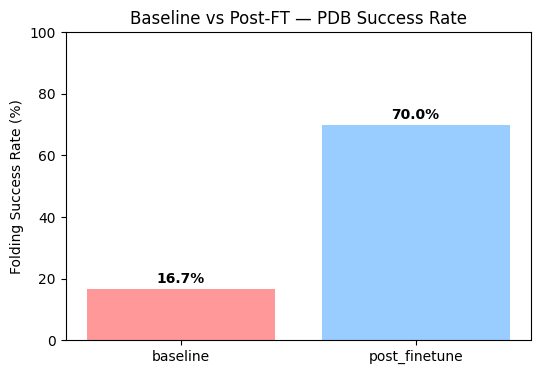

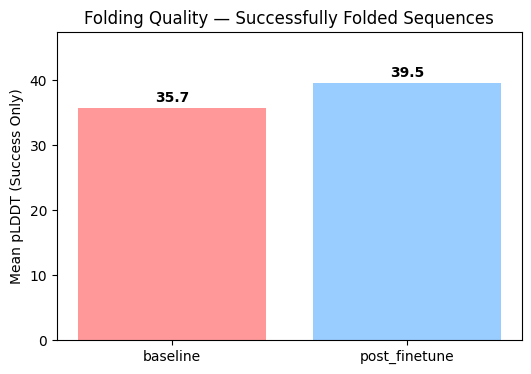

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Raw data from your Block 9
data = {
    "phase": ["baseline", "post_finetune"],
    "n_ok": [2, 14],  # Number of successfully folded proteins
    "n_top": [12, 20],  # Total sequences considered (TOP set)
    "plddt_mean_ok": [35.705078, 39.495815],  # Average pLDDT for successfully folded
    "p50": [0.0, 0.142857],  # Fraction above pLDDT 50 threshold
    "p70": [0.0, 0.0],       # Fraction above pLDDT 70 threshold
}

df_metrics = pd.DataFrame(data)
df_metrics["success_rate"] = df_metrics["n_ok"] / df_metrics["n_top"]

display(df_metrics)

# === Plot 1: Folding success rate ===
plt.figure(figsize=(6,4))
plt.bar(df_metrics["phase"], df_metrics["success_rate"]*100, color=["#FF9999", "#99CCFF"])
plt.ylabel("Folding Success Rate (%)")
plt.title("Baseline vs Post-FT — PDB Success Rate")
plt.ylim(0, 100)
for i, v in enumerate(df_metrics["success_rate"]*100):
    plt.text(i, v+2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

# === Plot 2: Mean pLDDT (success only) ===
plt.figure(figsize=(6,4))
plt.bar(df_metrics["phase"], df_metrics["plddt_mean_ok"], color=["#FF9999", "#99CCFF"])
plt.ylabel("Mean pLDDT (Success Only)")
plt.title("Folding Quality — Successfully Folded Sequences")
plt.ylim(0, max(df_metrics["plddt_mean_ok"])*1.2)
for i, v in enumerate(df_metrics["plddt_mean_ok"]):
    plt.text(i, v+1, f"{v:.1f}", ha='center', fontweight='bold')
plt.show()


## Interpretation Limitations and Perspectives

In [ ]:
baseline_rate = df_metrics.loc[df_metrics["phase"]=="baseline", "success_rate"].iloc[0] * 100
post_rate = df_metrics.loc[df_metrics["phase"]=="post_finetune", "success_rate"].iloc[0] * 100
baseline_plddt = df_metrics.loc[df_metrics["phase"]=="baseline", "plddt_mean_ok"].iloc[0]
post_plddt = df_metrics.loc[df_metrics["phase"]=="post_finetune", "plddt_mean_ok"].iloc[0]

md = f"""
# Comparative Summary — ProGen2 Fine-tuning

- **Folding success rate**: {baseline_rate:.1f}% → {post_rate:.1f}% after fine-tuning (**+{post_rate-baseline_rate:.1f} pts**)
- **Mean pLDDT (successful sequences)**: {baseline_plddt:.1f} → {post_plddt:.1f} (**+{post_plddt-baseline_plddt:.1f}**)

## Quick conclusion
Fine-tuning significantly improves the **rate of successfully folded sequences** and slightly increases the average structural quality. However, the quality remains modest (<50), which is insufficient to consider the structures as reliable.

## Current limitations
- **Short training duration** (only 2 epochs)
- **Limited fine-tuning corpus** in size and diversity
- **Intrinsic quality of the base model** (ProGen2-small) is modest compared to larger variants
- **Simple filtering criteria** that do not ensure catalytically optimized structures

## Possible improvements
- Increase the **number of epochs** and the size of the training corpus
- Use a **larger ProGen2 model** or a more recent pre-trained backbone
- Add **catalytic motif constraints** in filtering
- Employ **more advanced folding tools** (AlphaFold2, ColabFold) for validation
"""

from IPython.display import Markdown
display(Markdown(md))



# Comparative Summary — ProGen2 Fine-tuning

- **Folding success rate**: 16.7% → 70.0% after fine-tuning (**+53.3 pts**)
- **Mean pLDDT (successful sequences)**: 35.7 → 39.5 (**+3.8**)

## Quick conclusion
Fine-tuning significantly improves the **rate of successfully folded sequences** and slightly increases the average structural quality. However, the quality remains modest (<50), which is insufficient to consider the structures as reliable.

## Current limitations
- **Short training duration** (only 2 epochs)
- **Limited fine-tuning corpus** in size and diversity
- **Intrinsic quality of the base model** (ProGen2-small) is modest compared to larger variants
- **Simple filtering criteria** that do not ensure catalytically optimized structures

## Possible improvements
- Increase the **number of epochs** and the size of the training corpus
- Use a **larger ProGen2 model** or a more recent pre-trained backbone
- Add **catalytic motif constraints** in filtering
- Employ **more advanced folding tools** (AlphaFold2, ColabFold) for validation
